![alt text](https://upload.wikimedia.org/wikipedia/commons/2/22/ENSAE_logo_developpe.jpg)

### Imports
Firt of all, a few imports that will be usefull later on.

In [1]:
import sys
print(sys.version)
import warnings
warnings.filterwarnings('ignore')

3.6.3 (default, Nov  6 2017, 23:09:57) 
[GCC 4.2.1 Compatible Apple LLVM 9.0.0 (clang-900.0.38)]


In [2]:
import os
import numpy as np
import pandas as pd
import scipy.stats as ss
from tqdm import tqdm

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler

from keras.models import Model
from keras.layers import Dense, Input

import seaborn as sns
from matplotlib import pylab, pyplot as plt
%matplotlib inline
sns.set_context("talk")
sns.set_style("whitegrid")
pylab.rcParams["figure.figsize"] = (16, 8)

Using TensorFlow backend.


### Paths setup
To run the notebook, please extract the "us_census_full.zip" file and point the DATA_PATH variable to the resulting folder's path.

In [3]:
DATA_PATH = "us_census_full"
METADATA_PATH = os.path.join(DATA_PATH, "census_income_metadata_modified.txt")
TRAIN_DATA_PATH = os.path.join(DATA_PATH, "census_income_learn.csv")
TEST_DATA_PATH = os.path.join(DATA_PATH, "census_income_test.csv")

# Technical Test

## Problem Definition

Given an anonymized sample of the US Census dataset, the objective is to **model** then **predict** the variable that tells us which people make more or less than $50,000/year. In order to do so we will use the provided "training" dataset and try to mine interesting features to predict the values on new samples from the "test" dataset.

If we had to make assumptions, we would say that :

* People with a greater **level of education** tend to have a greater income.
* People that come from a **richer background** tend to have a greater income.
* People in certain **geographic areas** would have a greater income than those from other areas.
* To a certain degree, the income would increase with **the age**.
* Due to some inequalities, the income could vary as a function of **sex and race**.
* One's income is direcly correlated with his/her **discipline**.
* ...

### Data Preparation/Preview

The first thing we can do with the training data is to :

* Check for/remove duplicates
* Compute the frequencies of each target class and check the class balance
* Check for and compute the number of missing values (NaN)
* Eventually replace these values according to the type of feature they're coming from
* Use the metadata file to name the features and convert them to the proper data type

The next function does just that :

In [4]:
# A function to load the data and name the columns using a metadata file
def get_data(path, drop_duplicated=True):
    
    data = pd.read_csv(path, header=None, sep=", ")
    print("The dataset has {} lines and {} columns.".format(*data.shape))
    if drop_duplicated:
        is_duplicate = data.duplicated()
        print("There are {} duplicate rows".format(is_duplicate.sum()))
        data = data[~is_duplicate]
        print("Removed duplicates. The new dataset has {} lines and {} columns.".format(*data.shape))
    
    target = data.pop(41)
    description = target.describe()
    unique = set(target.values)

    print('The target has {} distinct values : "{}" and "{}"'.format(description["unique"], *unique))
    print(('The value "{}" is the most common with a ' +
           "frequency of {:.2f}%.").format(description["top"], description["freq"]*100/description["count"]))
    
    target.replace("50000+.", 1, inplace=True)
    target.replace("- 50000.", 0, inplace=True)
    print('Replaced the target modalities with 0 and 1 for "- 50000." and "50000+." respectively.')
    
    # Only feature with NaN => Solution : Put the observations in the 'Do not know' class.
    data.loc[data[11].isnull(), 11] = 'Do not know'
    print('Replaced NaN in "type of hispanic" feature with "Do not know".')

    # No other features with missing values.
    print("Number of remaining NaN values in dataset : {}".format(data.isnull().sum().sum()))
    
    # Use metadata to re-format dataset
    with open(METADATA_PATH, 'r') as f:
        columns = []
        dtypes = []
        for line in f:
            line = line.strip()
            line = line.split('(')[-1]
            name , dtype = line.split(')')
            dtype = dtype.split(' ')[-1]

            columns.append(name)
            dtypes.append(dtype)

    noname = data.pop(24)
    noname.name = 'NoName'

    data.columns = columns
    for i, c in enumerate(data.columns):
        if dtypes[i] == "continuous":
            data[c] = data[c].astype(float)
        elif dtypes[i] == "nominal":
            data[c] = data[c].astype(str)

    data = data.join(noname)
    
    counts = data.dtypes.value_counts()

    n_categ = counts.loc[np.dtype('O')]
    n_num = counts.loc[np.dtype('float64')]
    
    print("Number of numerical features : {}".format(n_num))
    print("Number of categorical features : {}".format(n_categ))
    
    return data, target

Let's load and have a quick look at the training data.

In [5]:
data, target = get_data(TRAIN_DATA_PATH)
data.head(n=3)

The dataset has 199523 lines and 42 columns.
There are 3229 duplicate rows
Removed duplicates. The new dataset has 196294 lines and 42 columns.
The target has 2 distinct values : "- 50000." and "50000+."
The value "- 50000." is the most common with a frequency of 93.69%.
Replaced the target modalities with 0 and 1 for "- 50000." and "50000+." respectively.
Replaced NaN in "type of hispanic" feature with "Do not know".
Number of remaining NaN values in dataset : 0
Number of numerical features : 8
Number of categorical features : 33


,age,class of worker,detailed industry recode,detailed occupation recode,education,wage per hour,enroll in edu inst last wk,marital stat,major industry code,major occupation code,...,country of birth father,country of birth mother,country of birth self,citizenship,own business or self employed,fill inc questionnaire for veteran's admin,veterans benefits,weeks worked in year,year,NoName
0,73.0,Not in universe,0,0,High school graduate,0.0,Not in universe,Widowed,Not in universe or children,Not in universe,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,0.0,95,1700.09
1,58.0,Self-employed-not incorporated,4,34,Some college but no degree,0.0,Not in universe,Divorced,Construction,Precision production craft & repair,...,United-States,United-States,United-States,Native- Born in the United States,0,Not in universe,2,52.0,94,1053.55
2,18.0,Not in universe,0,0,10th grade,0.0,High school,Never married,Not in universe or children,Not in universe,...,Vietnam,Vietnam,Vietnam,Foreign born- Not a citizen of U S,0,Not in universe,2,0.0,95,991.95


Let's describe the training data a bit. We observe the following :

* The training dataset has ~200,000 lines, 41 features and another column, the target feature.
* This target feature is **very** unbalanced with **93.79%** of people making less than $50,000 and **6.21%** making more than that.

    *Let's denote in the rest of the notebook the people making less than $50,000 as class **0** and the others as class **1**.*


* Among the features, 8 are numerical features and 33 are categorical.
* There are only few missing and they're all coming from the 11th column (hispanic origin). We replace these with the "Do not know" modality.

Let's go into a bit more detail and visualize the feature distribution.

### Feature distributions

#### Categorical features

Feature : class of worker


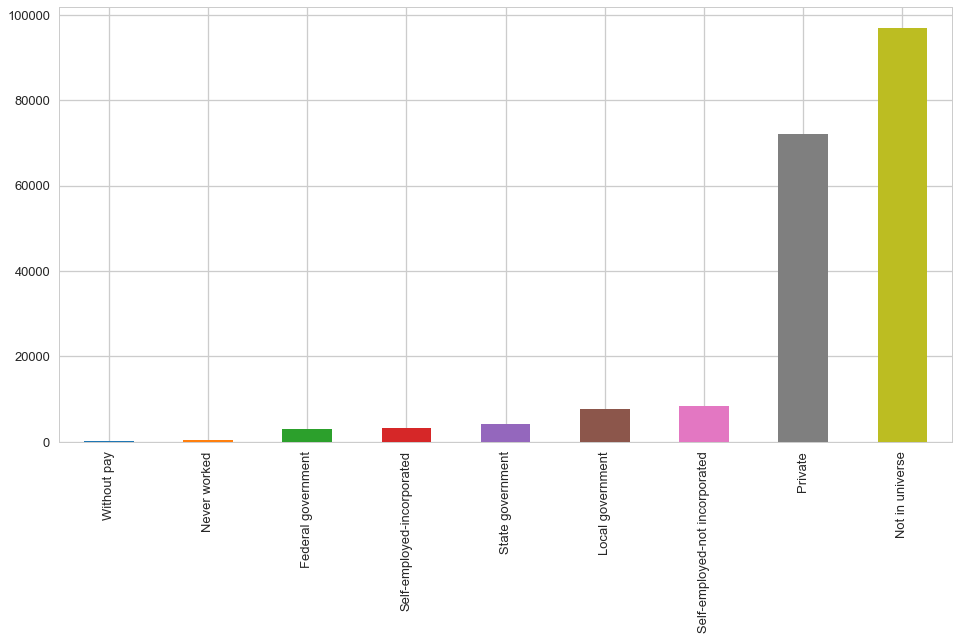


Feature : detailed industry recode


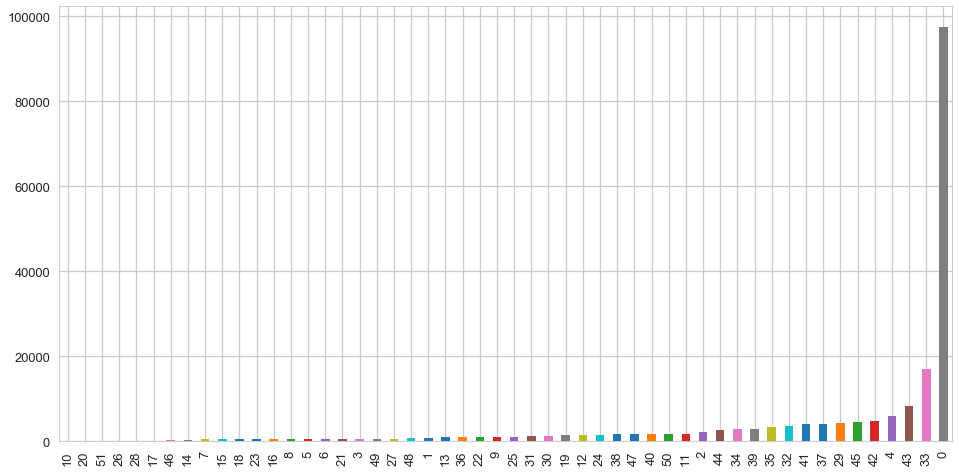


Feature : detailed occupation recode


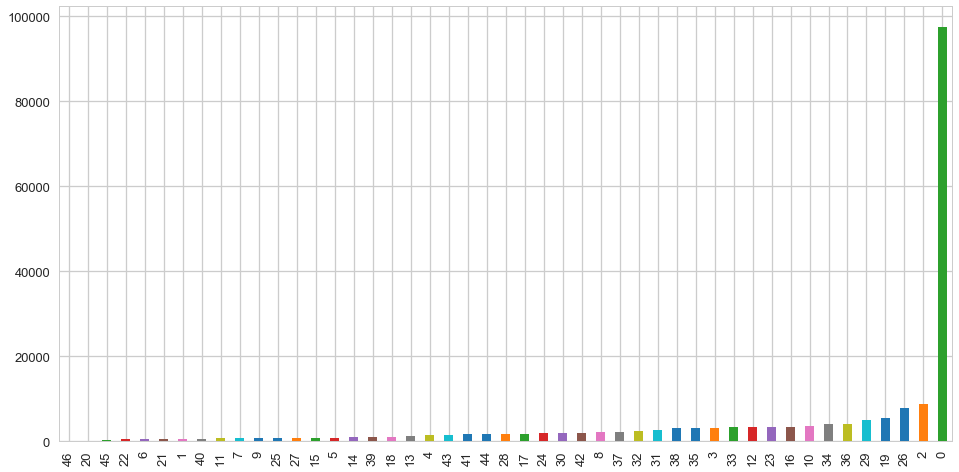


Feature : education


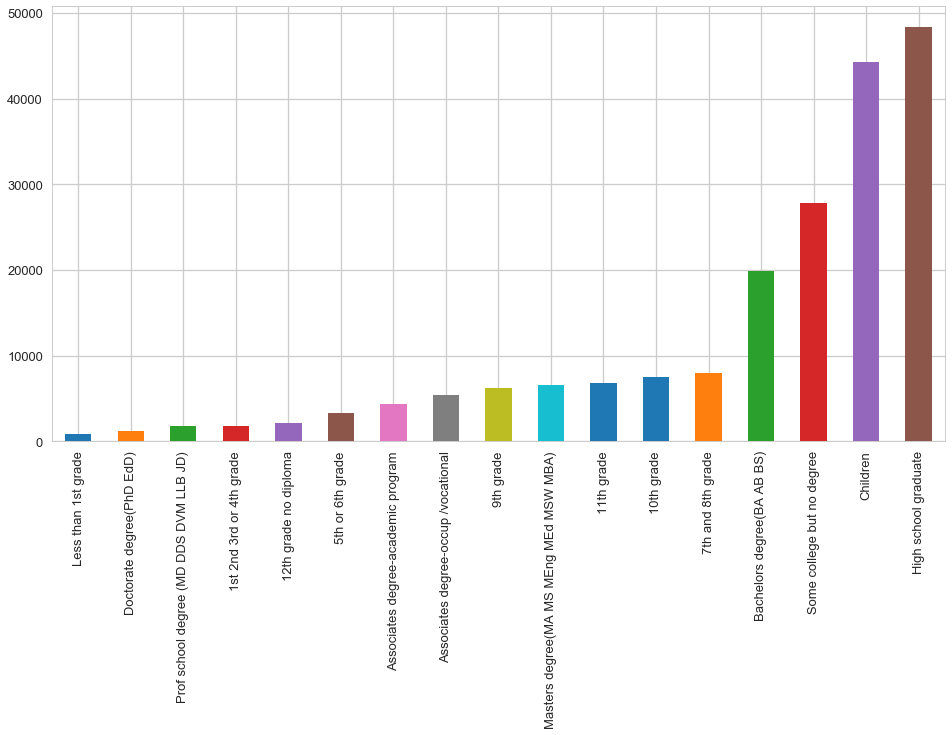


Feature : enroll in edu inst last wk


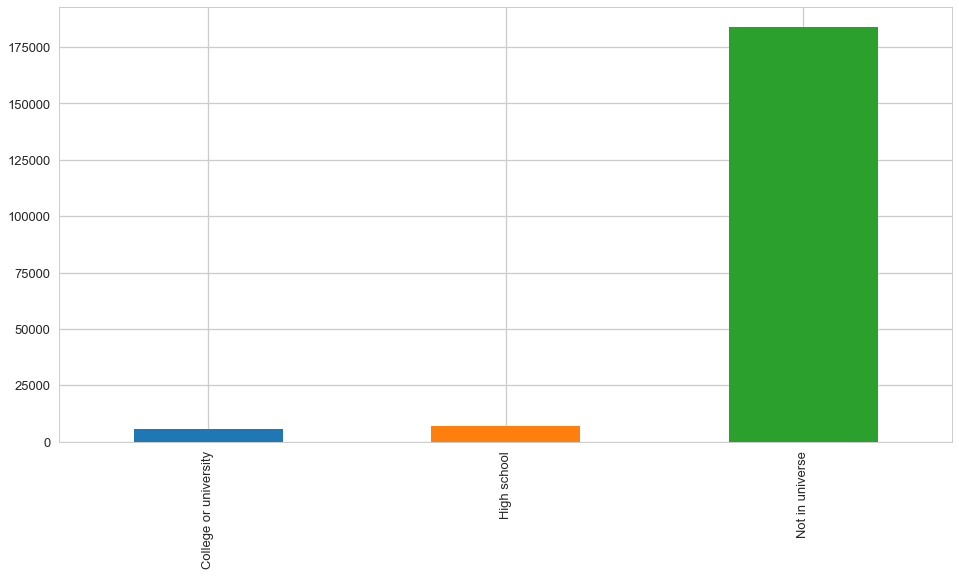


Feature : marital stat


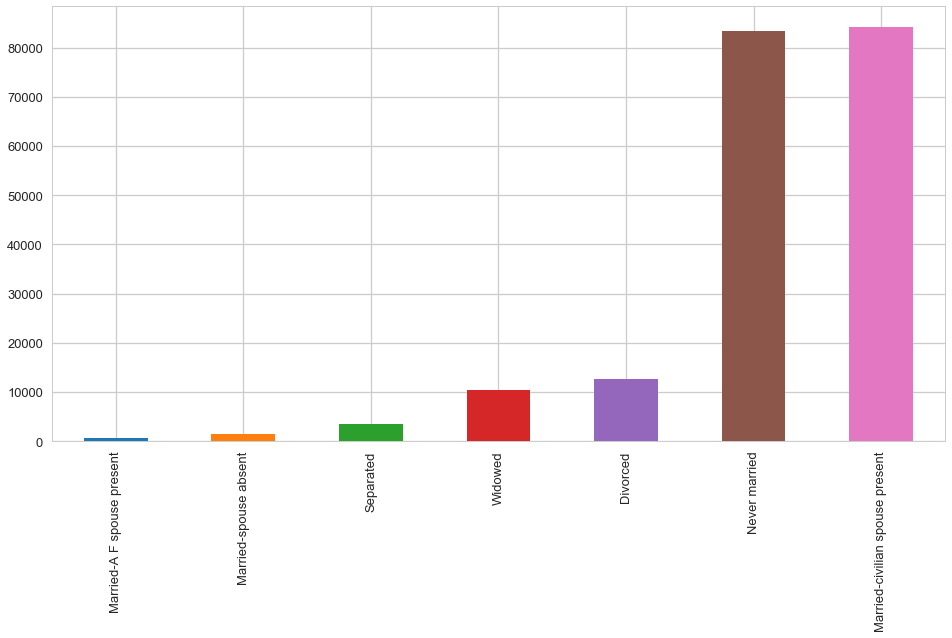


Feature : major industry code


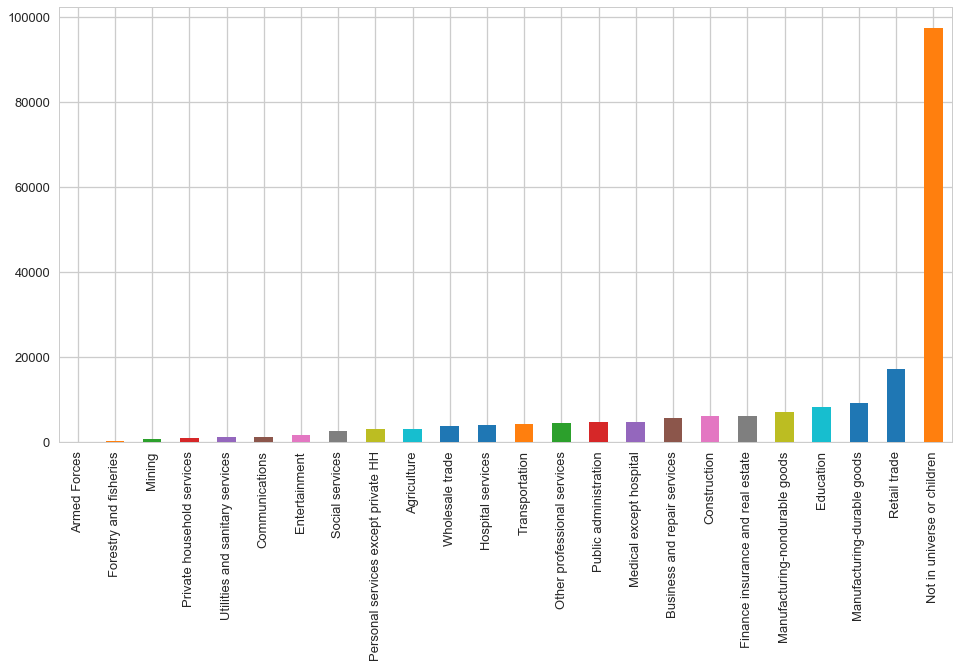


Feature : major occupation code


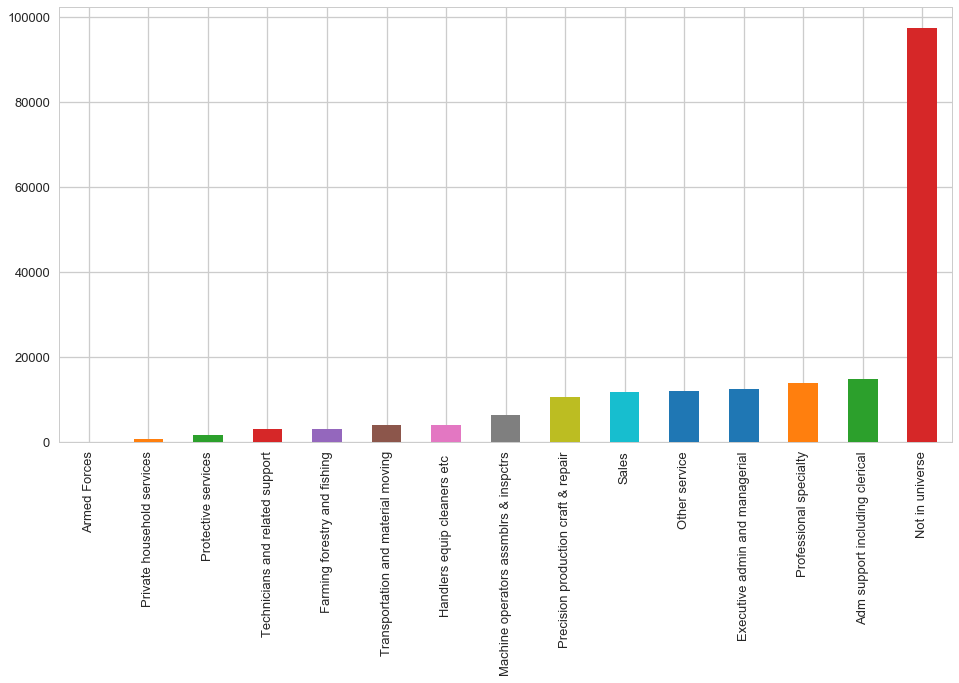


Feature : race


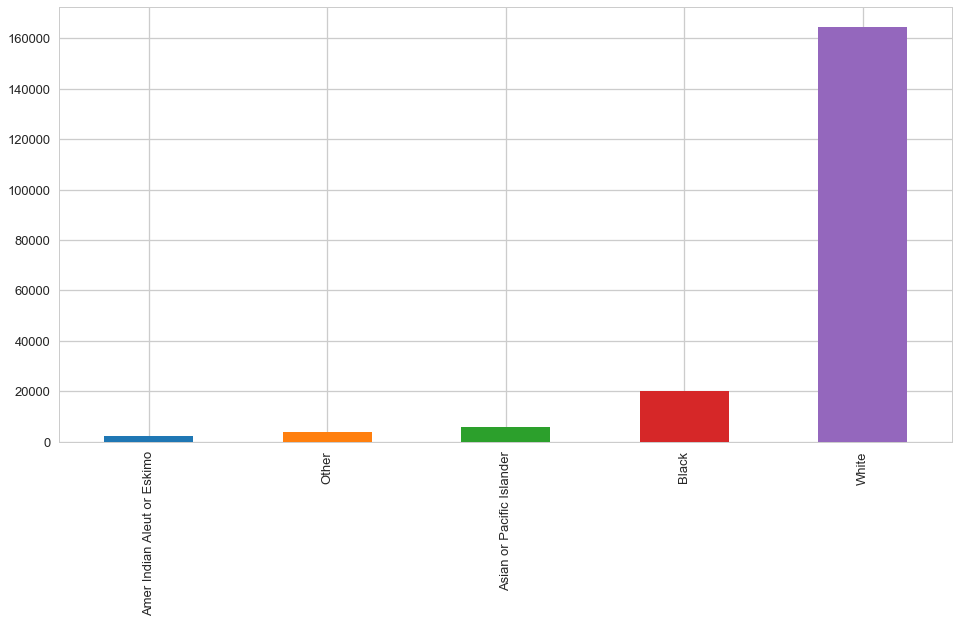


Feature : hispanic origin


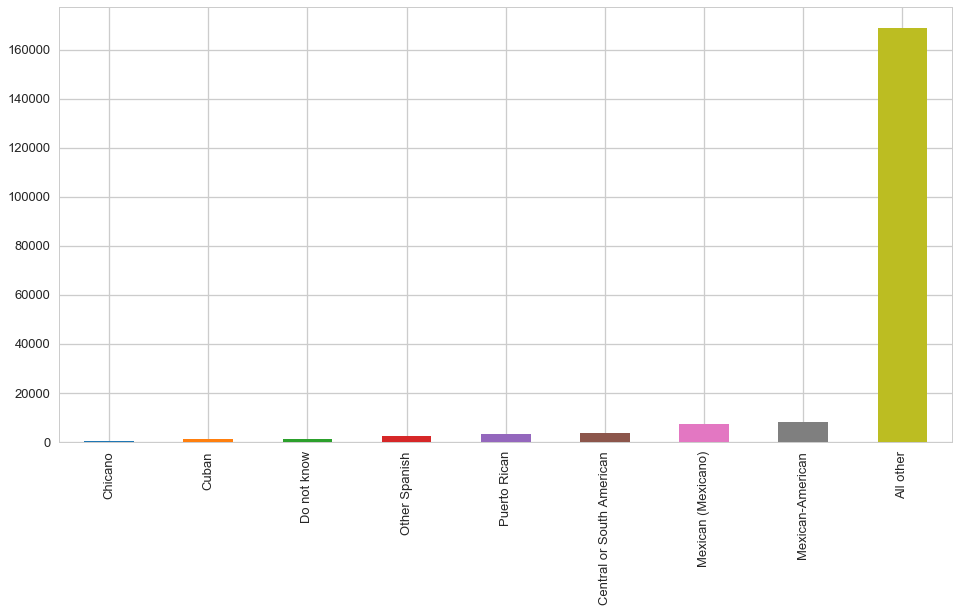


Feature : sex


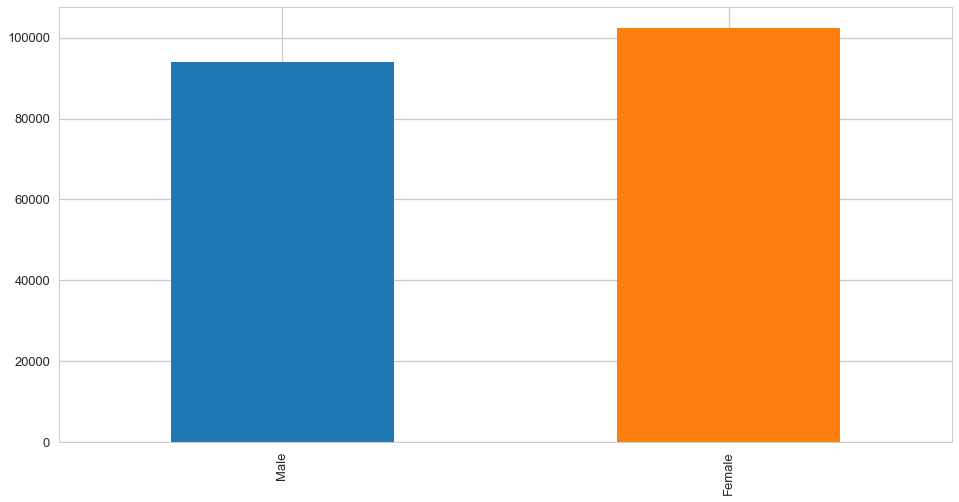


Feature : member of a labor union


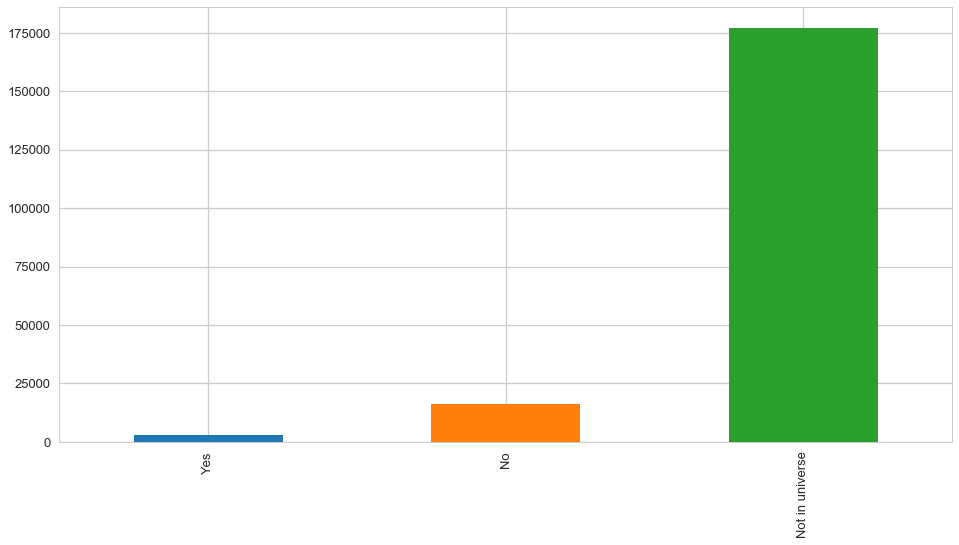


Feature : reason for unemployment


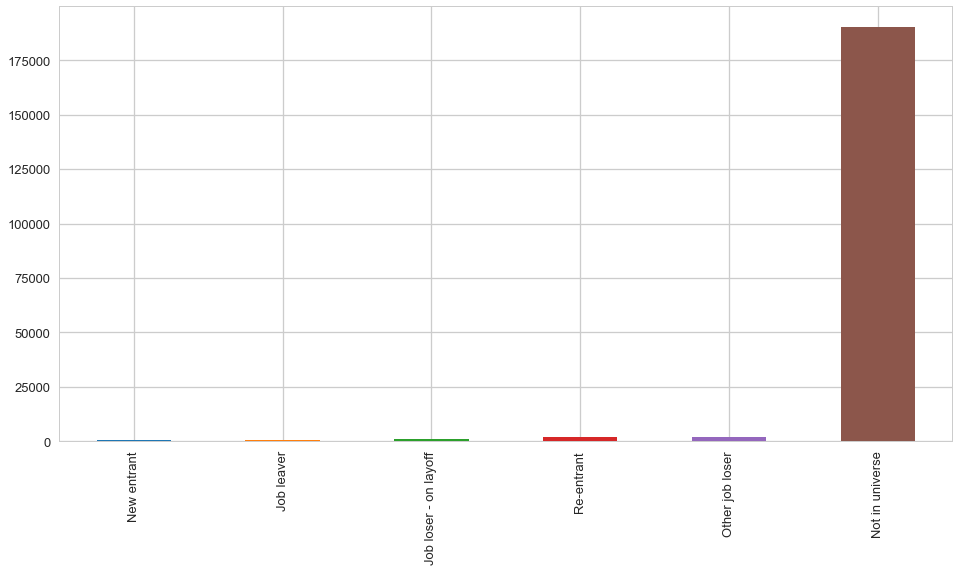


Feature : full or part time employment stat


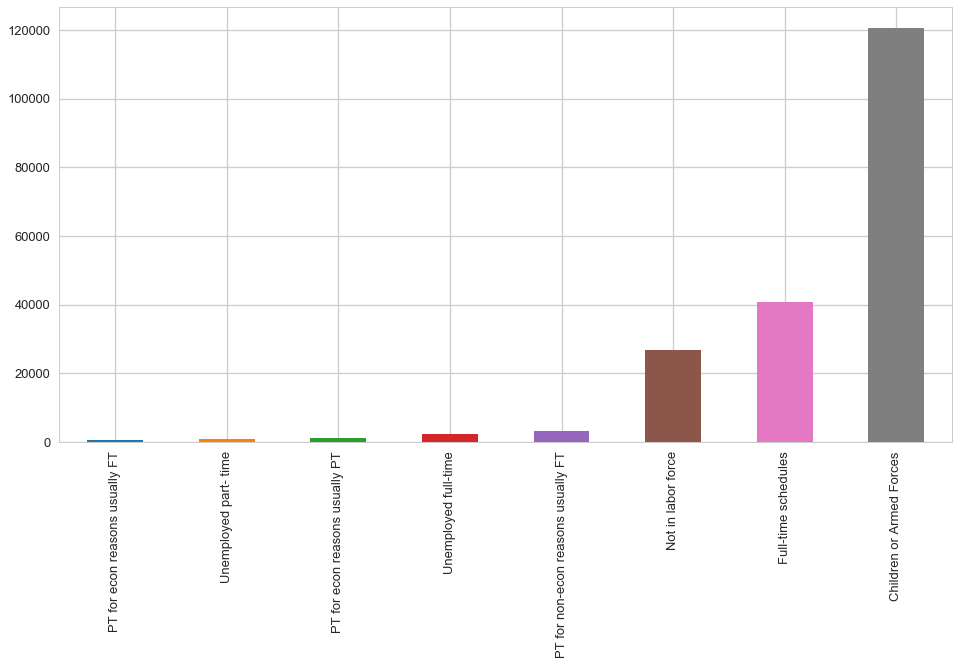


Feature : tax filer stat


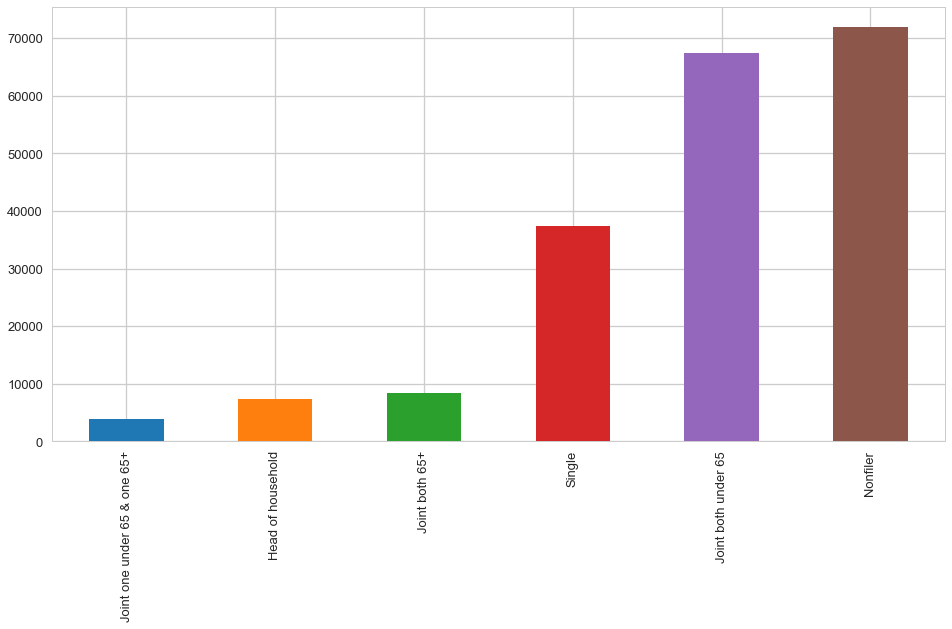


Feature : region of previous residence


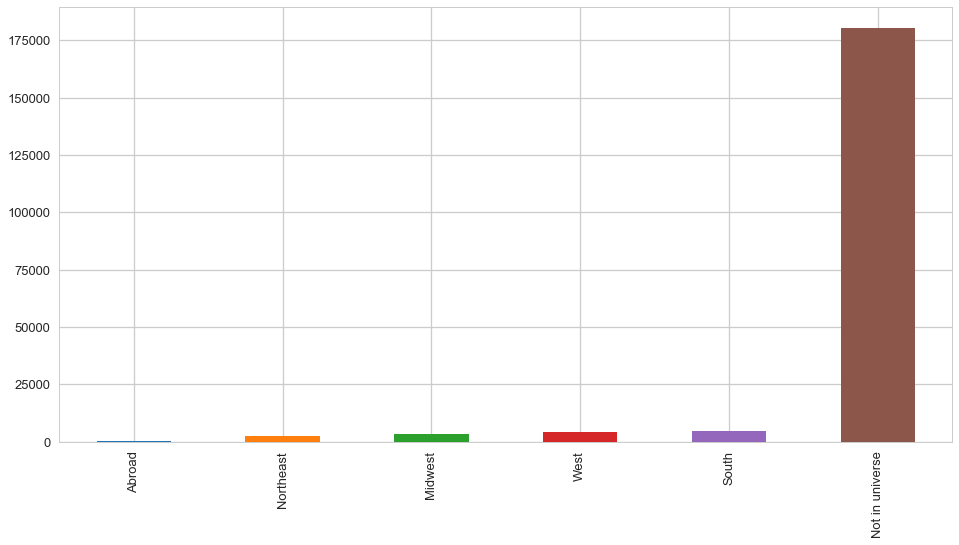


Feature : state of previous residence


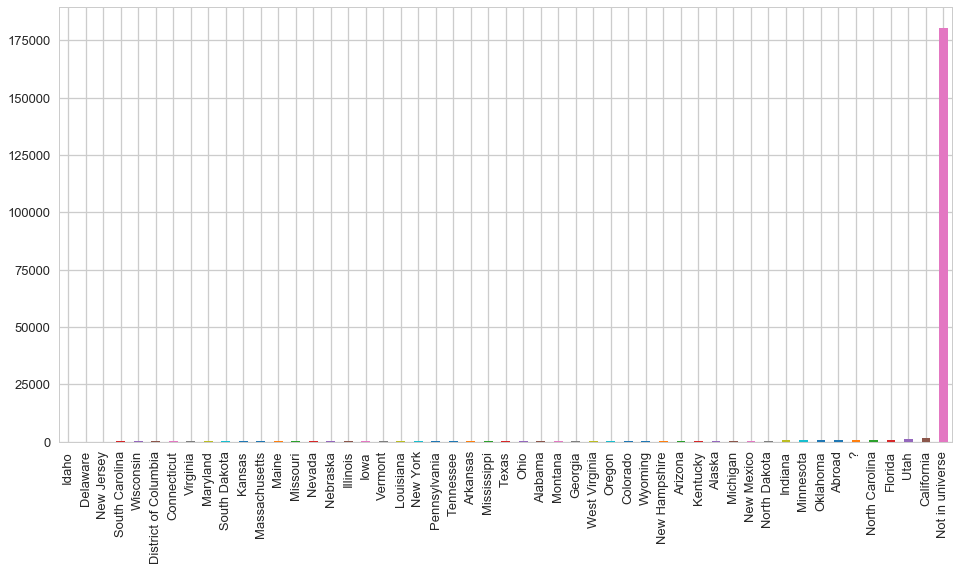


Feature : detailed household and family stat


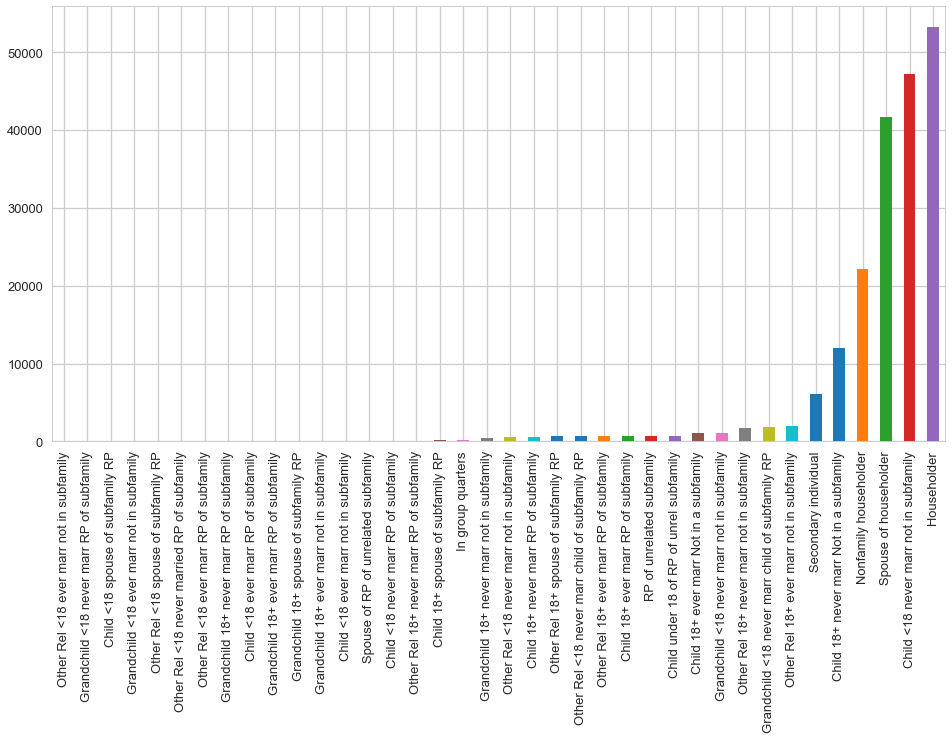


Feature : detailed household summary in household


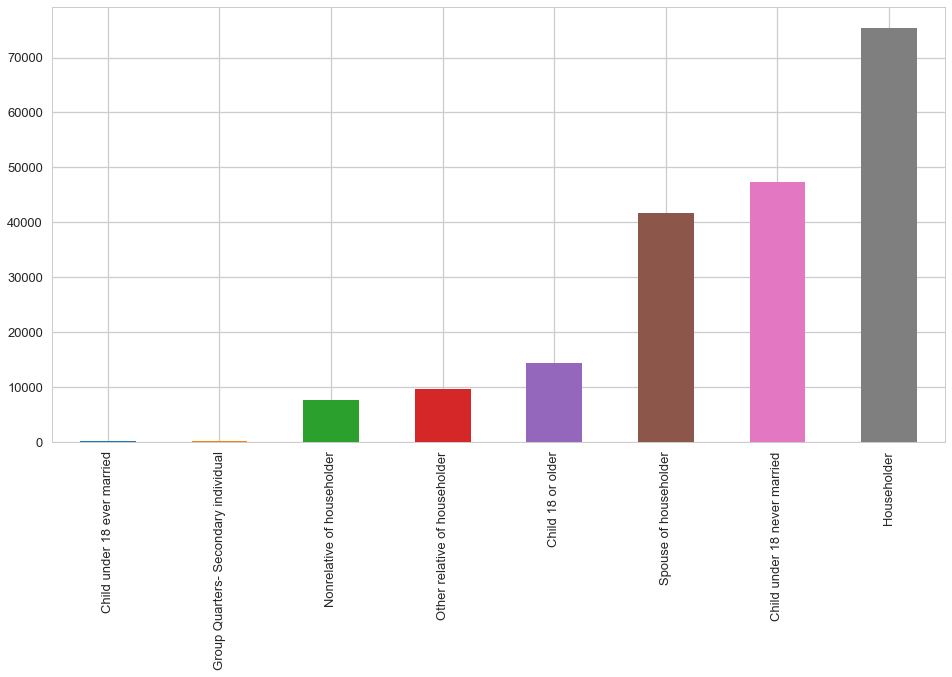


Feature : migration code-change in msa


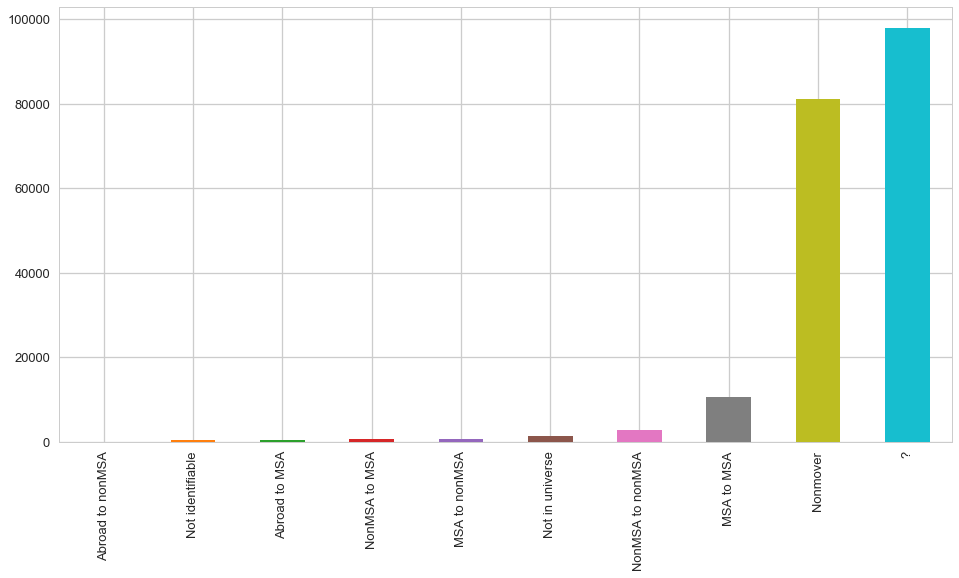


Feature : migration code-change in reg


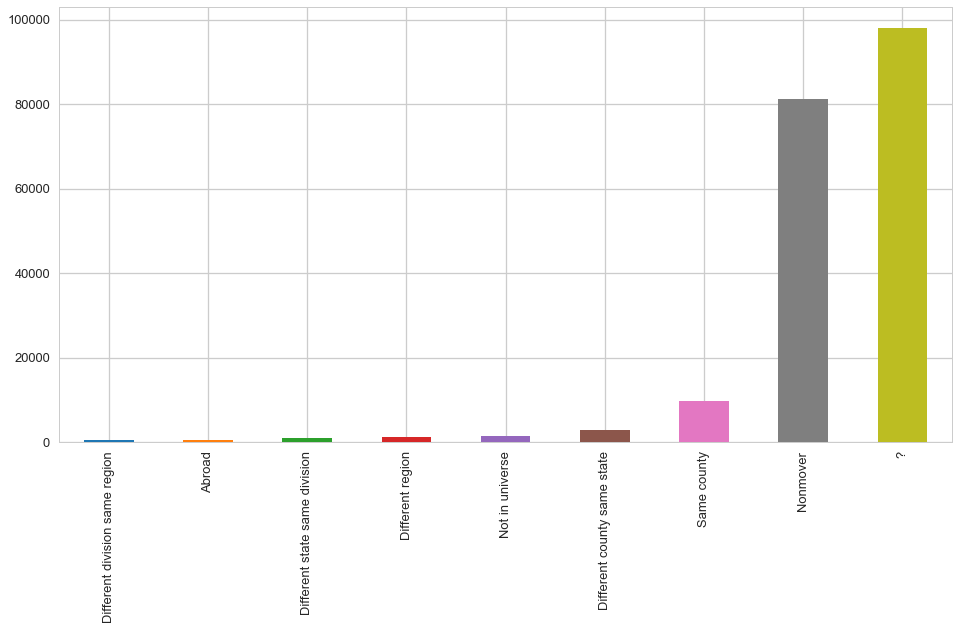


Feature : migration code-move within reg


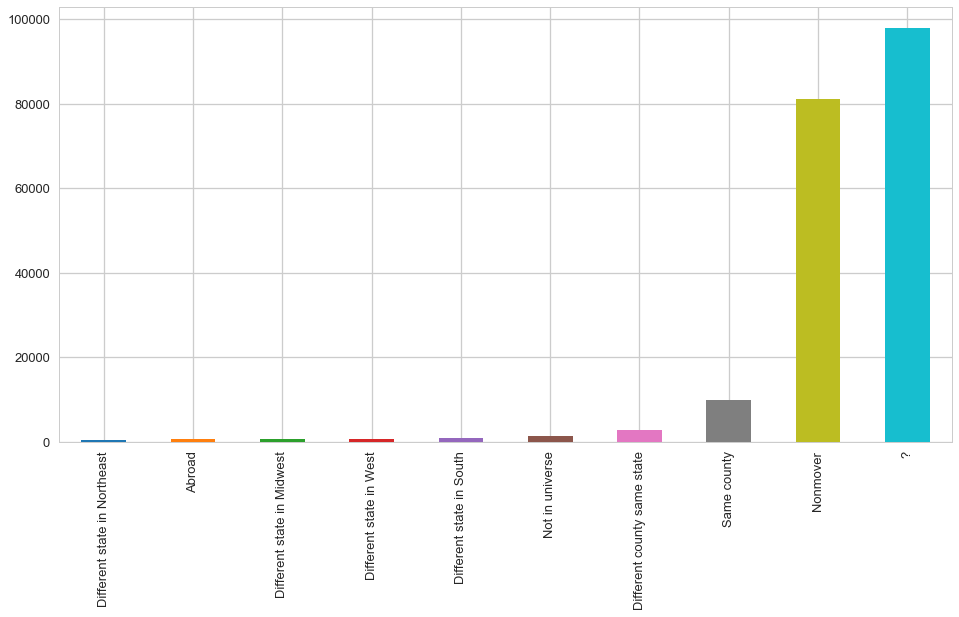


Feature : live in this house 1 year ago


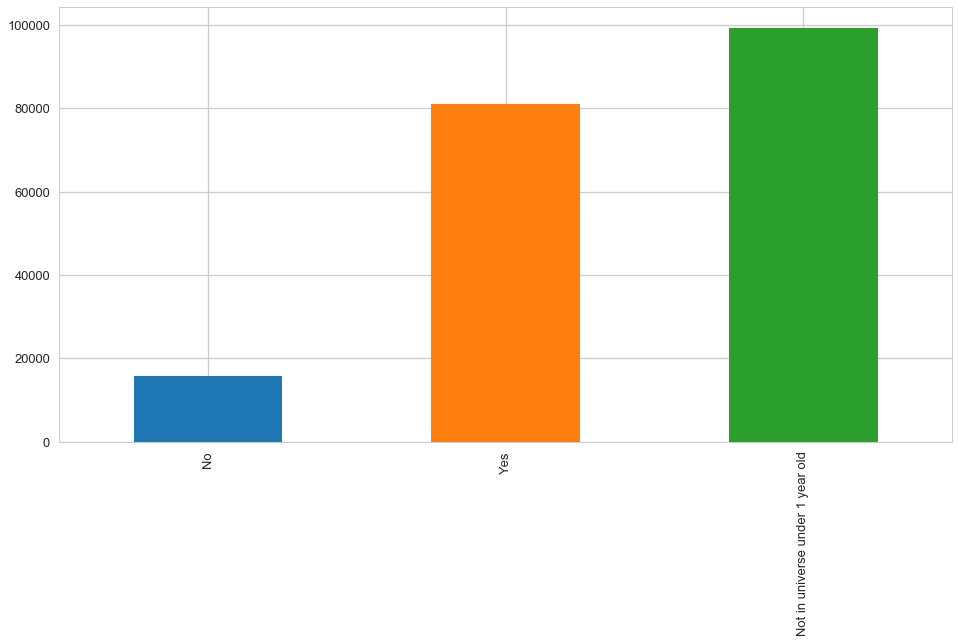


Feature : migration prev res in sunbelt


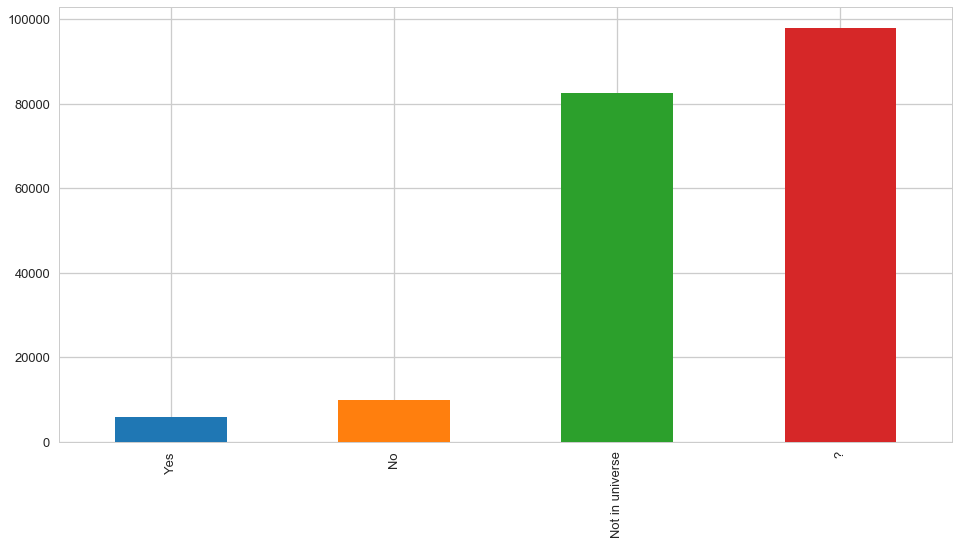


Feature : family members under 18


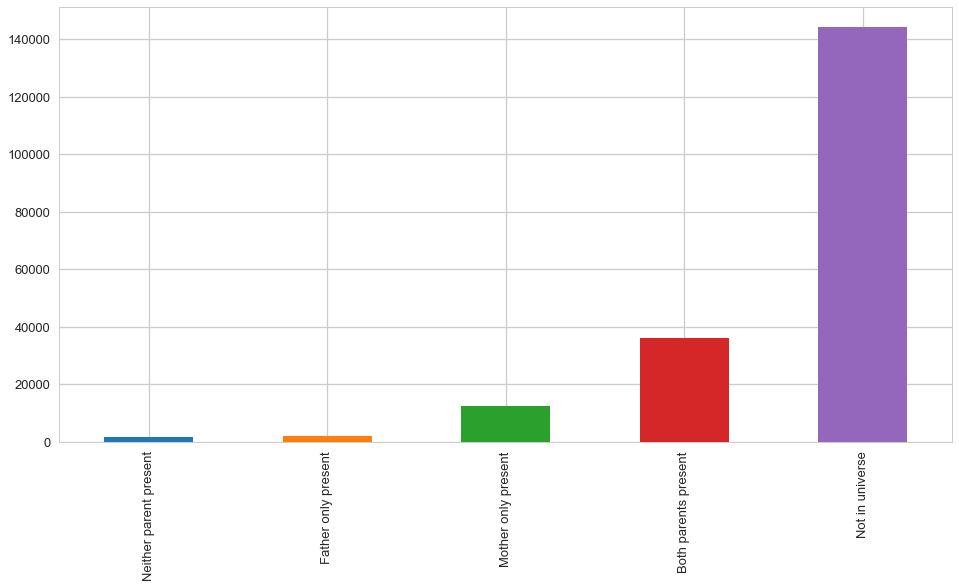


Feature : country of birth father


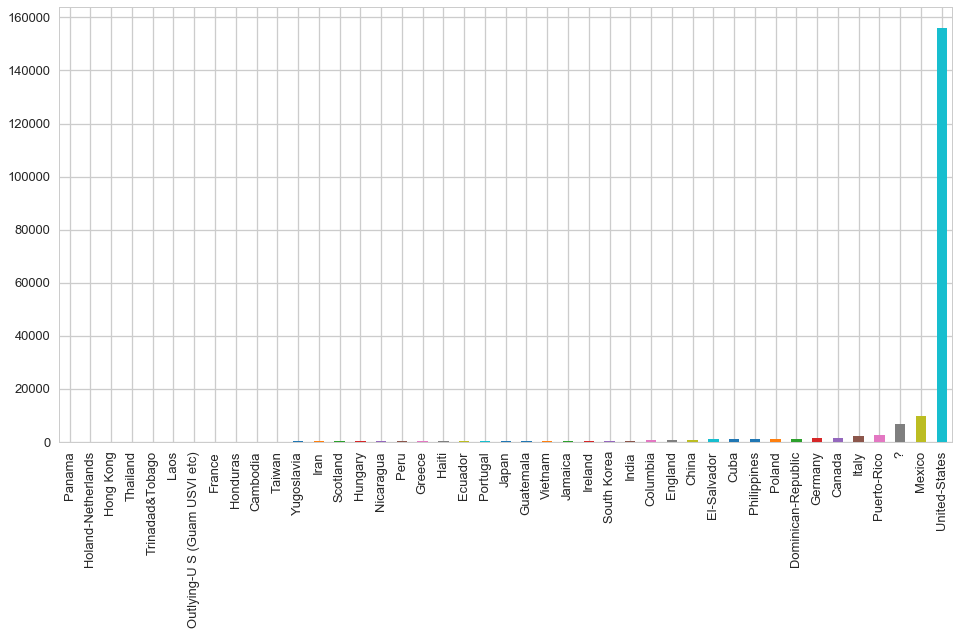


Feature : country of birth mother


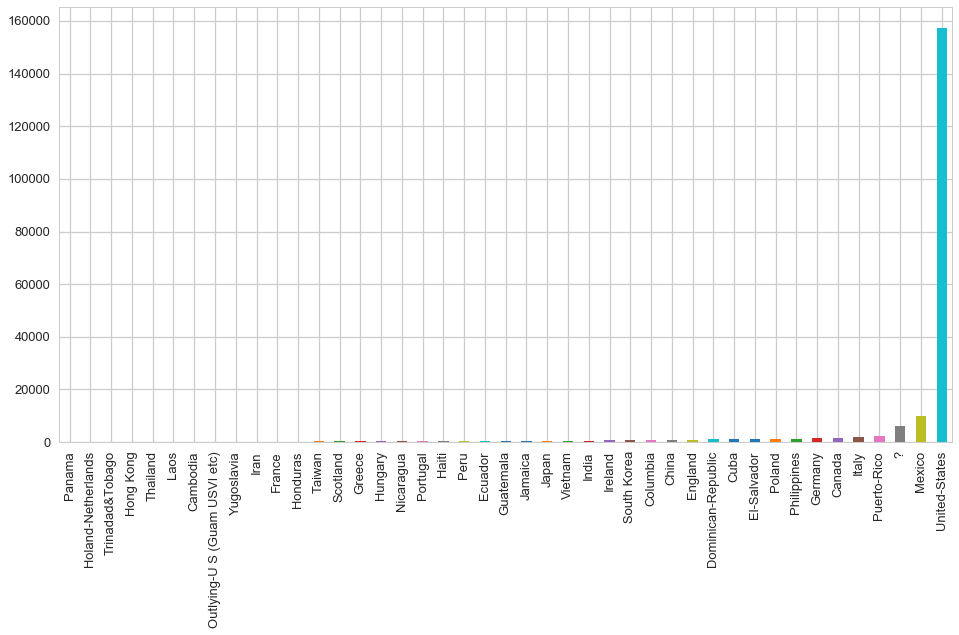


Feature : country of birth self


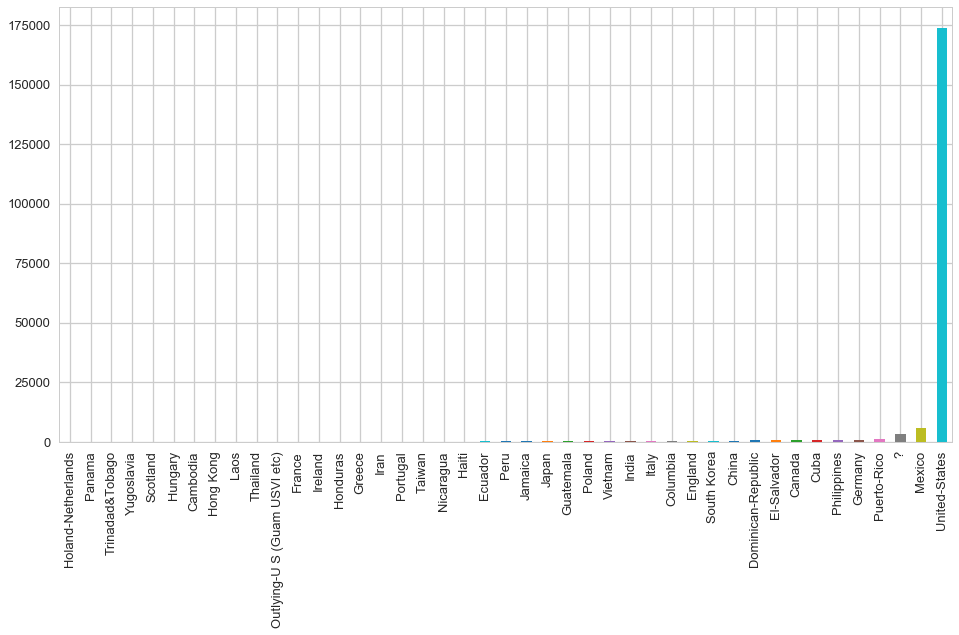


Feature : citizenship


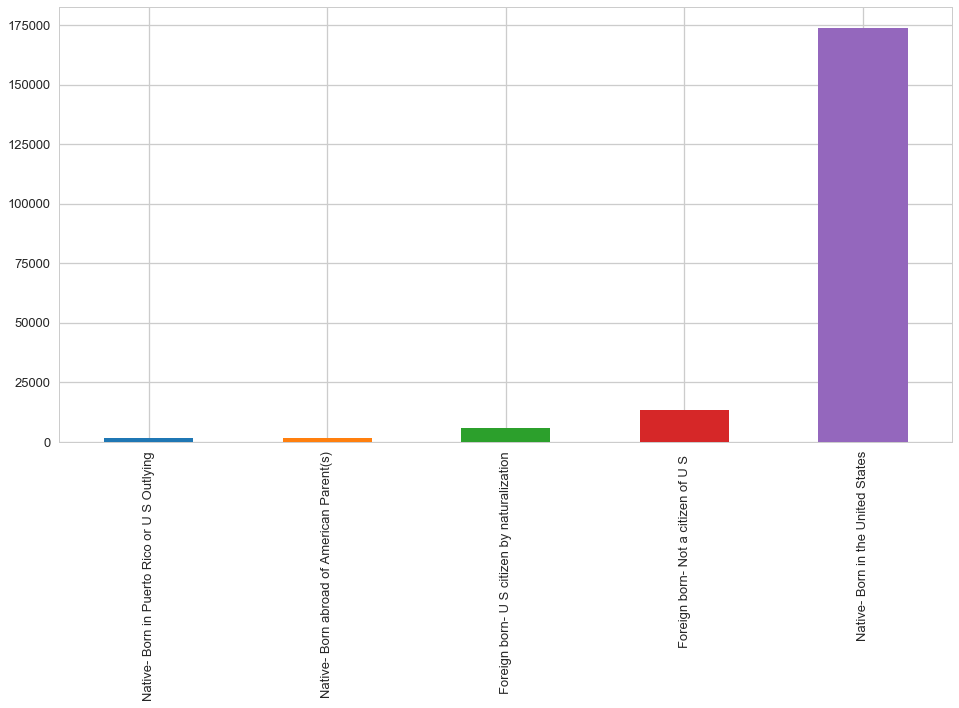


Feature : own business or self employed


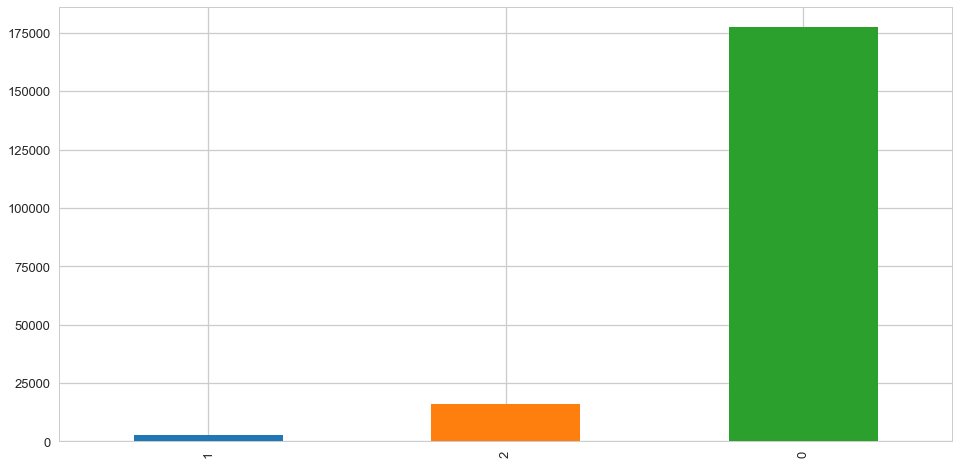


Feature : fill inc questionnaire for veteran's admin


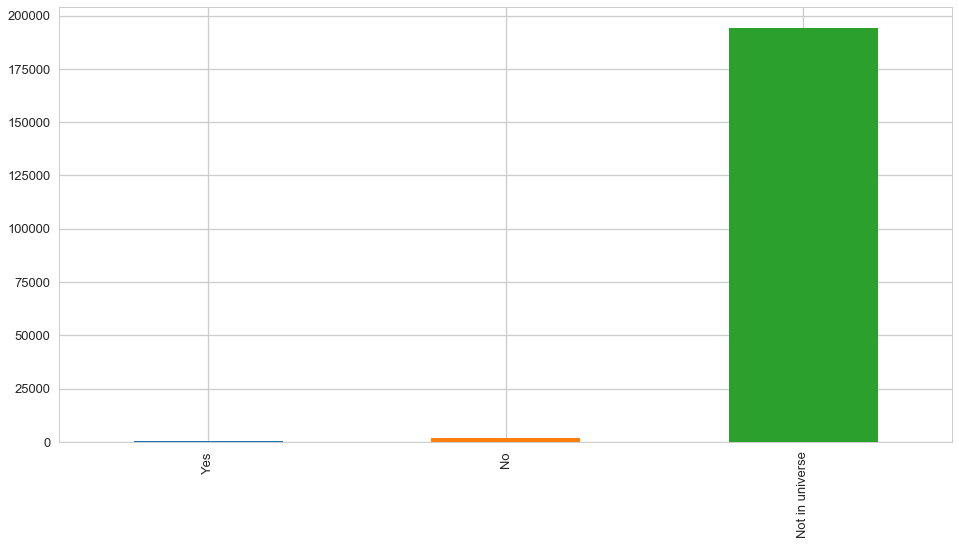


Feature : veterans benefits


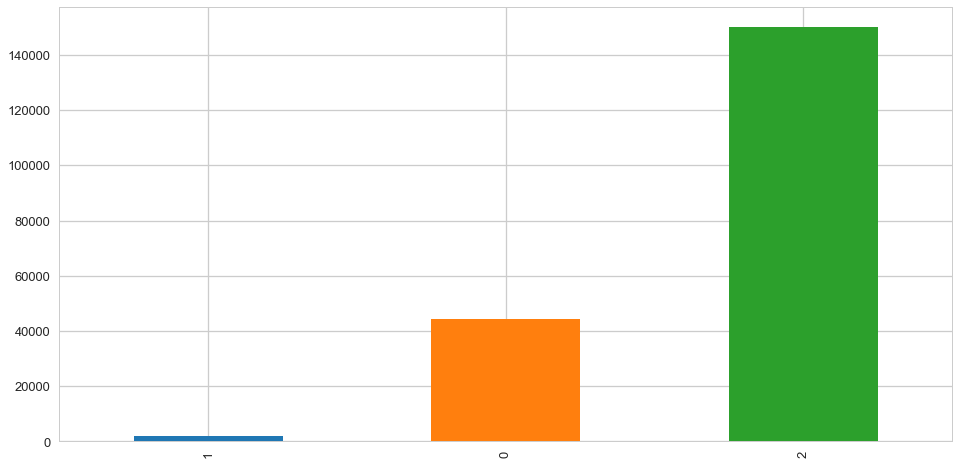


Feature : year


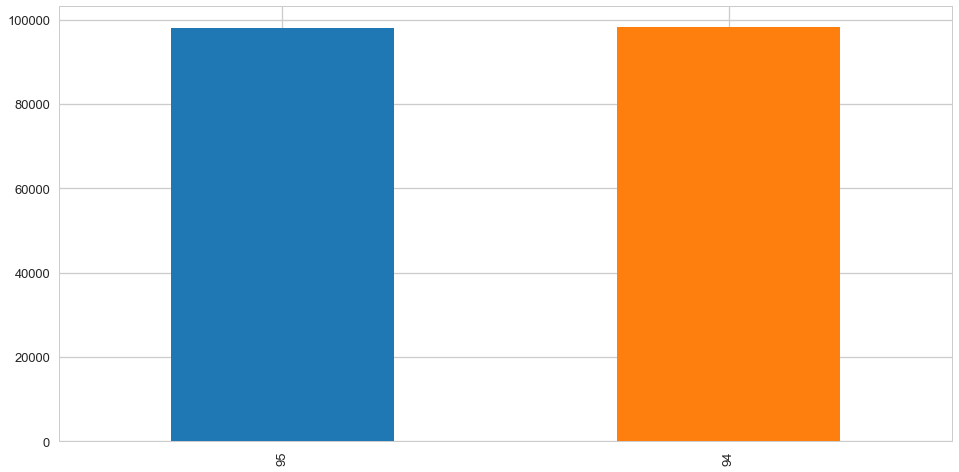

In [6]:
for c in data.select_dtypes("object"):
    print("Feature : {}".format(c))
    data[c].value_counts().sort_values().plot(kind="bar")
    plt.show()
    print()

#### Numerical features

Feature : age


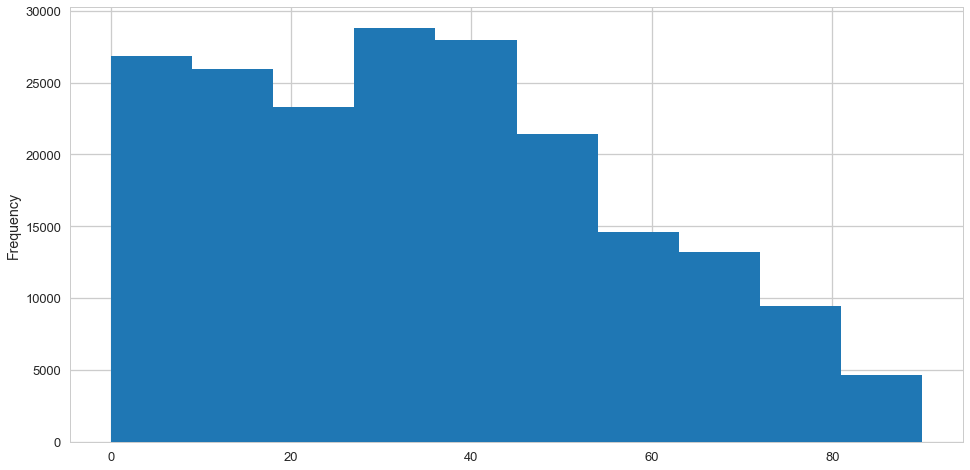


Feature : wage per hour


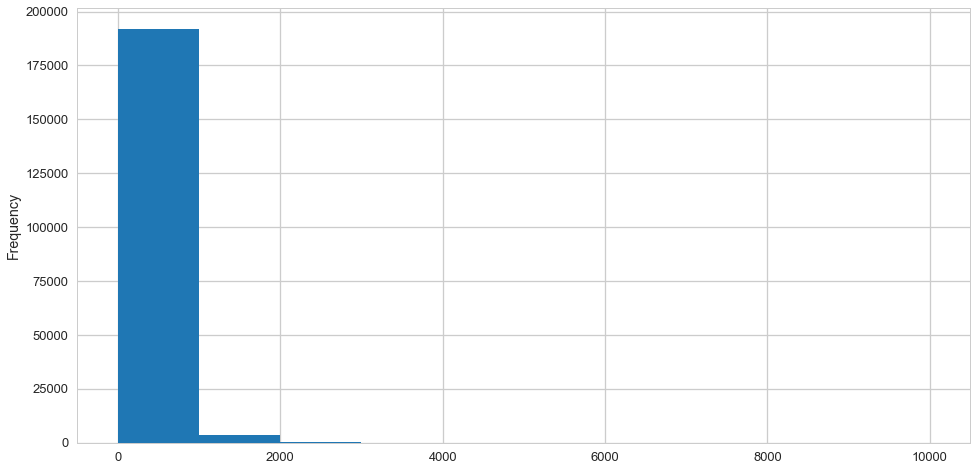


Feature : capital gains


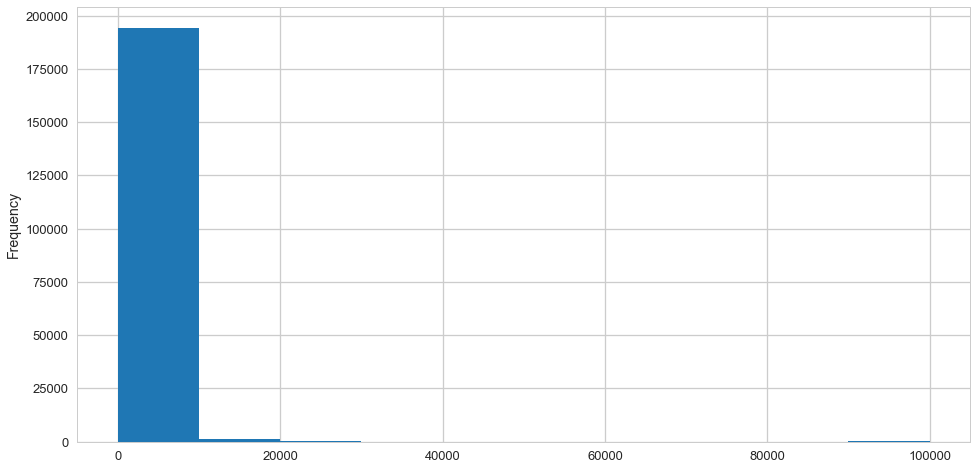


Feature : capital losses


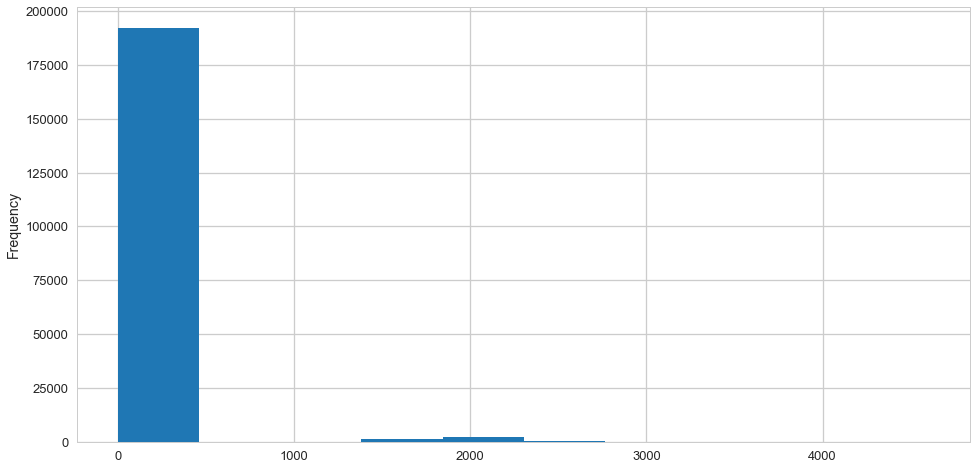


Feature : dividends from stocks


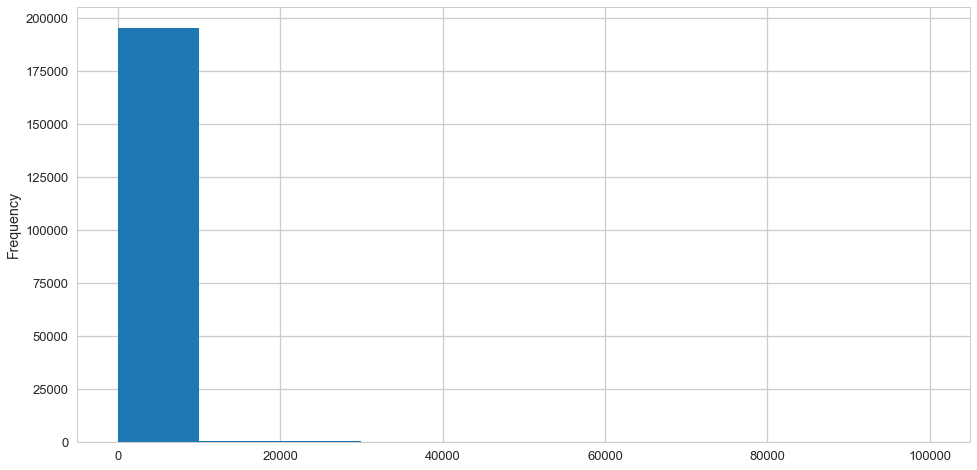


Feature : num persons worked for employer


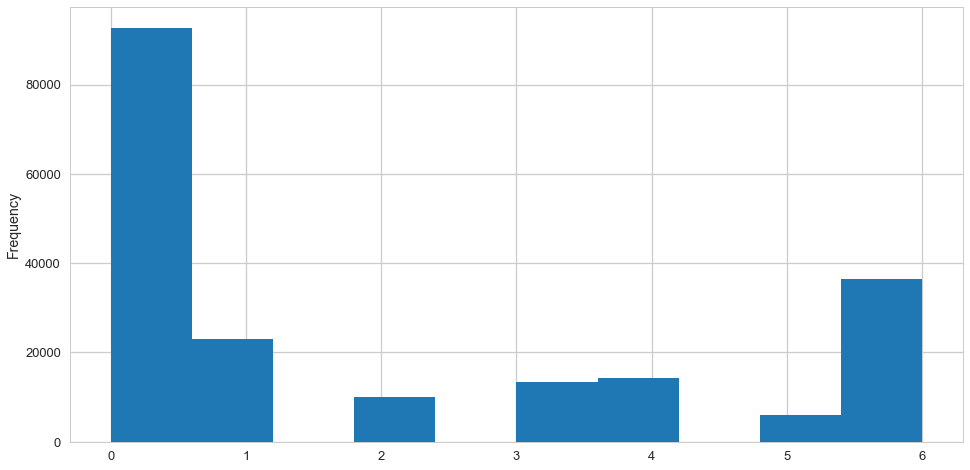


Feature : weeks worked in year


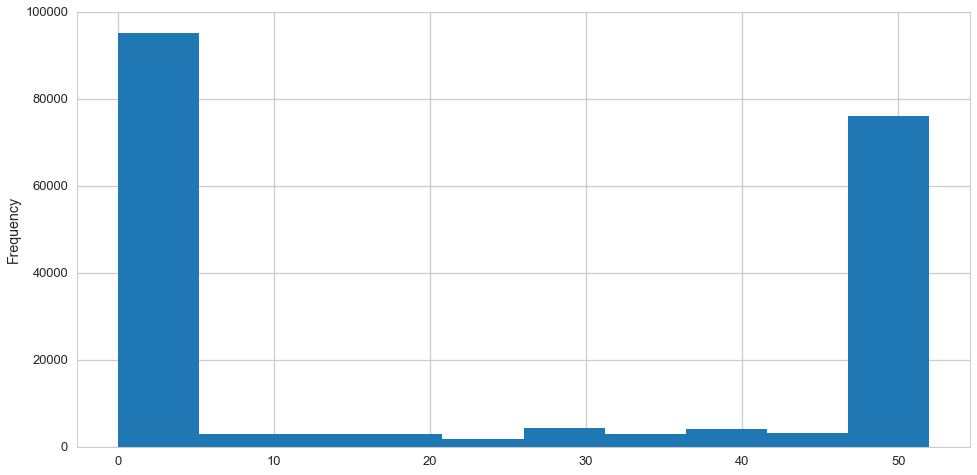


Feature : NoName


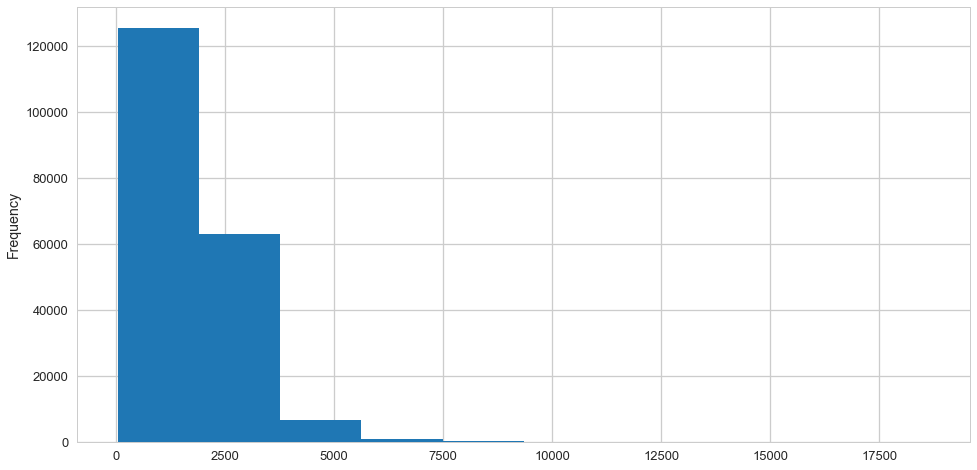

In [7]:
for c in data.select_dtypes(exclude="object"):
    print("Feature : {}".format(c))
    data[c].plot(kind="hist")
    plt.show()
    print()

One thing we can observe is that, for a lot of features, there are values (in the numerical case) or categories (in the categorical case) that are way more frequent than the others. Very often, these values are "garbage" values that might as well be NaNs, but let's just ignore that for the moment (we'll maybe get back to that later) and see how all of our features correlate to the variable we try to model.

### Correlations

In order to compute a correlation value between the target feature and a categorical feature we can use the V-Cramer statistic. (function below)

In [8]:
def cramers_corrected_stat(confusion_matrix):
    """ calculate Cramers V statistic for categorial-categorial association.
        uses correction from Bergsma and Wicher, 
        Journal of the Korean Statistical Society 42 (2013): 323-328
    """
    chi2 = ss.chi2_contingency(confusion_matrix)[0]
    n = confusion_matrix.sum().sum()
    phi2 = chi2/n
    r,k = confusion_matrix.shape
    phi2corr = max(0, phi2 - ((k-1)*(r-1))/(n-1))    
    rcorr = r - ((r-1)**2)/(n-1)
    kcorr = k - ((k-1)**2)/(n-1)
    return np.sqrt(phi2corr / min( (kcorr-1), (rcorr-1)))

Now that we have a way to compute the correlation for a categorical feature, let's see which features are the most correlated with the target. 

In [9]:
index = []
cramer = []
for c in data.select_dtypes("object"):
    index.append(c)
    confusion = pd.crosstab(target, data[c])
    cramer.append(cramers_corrected_stat(confusion))

categorcial_correlations = pd.Series(index=index, data=cramer)
numerical_correlations = data.select_dtypes(exclude="object").corrwith(target)

In [10]:
print("most correlated categorical features :", '\n')
print(categorcial_correlations.sort_values(ascending=False))
print()
print("most correlated numerical features :", '\n')
print(numerical_correlations.sort_values(ascending=False))

most correlated categorical features : 

detailed occupation recode                    0.436974
education                                     0.388594
major occupation code                         0.364915
detailed industry recode                      0.290883
major industry code                           0.275897
class of worker                               0.258584
detailed household and family stat            0.237968
tax filer stat                                0.226982
detailed household summary in household       0.224919
marital stat                                  0.195121
sex                                           0.159219
full or part time employment stat             0.158407
family members under 18                       0.155875
veterans benefits                             0.140868
own business or self employed                 0.083043
member of a labor union                       0.073683
country of birth father                       0.070589
country of birth mother 

We can see that the most correlated categorical features are those related to the **kind of job/industry** the person works in as well as the **level of education** he/she has. Surprisingly, features related to the **race/citizenship** are ranked relatively low. In the more correlated categorical features we find as well those related to the **familial status**.

As for the numerical features, the most correlated feature is the number of weeks the person has worked in a year while the feature saying how much the person is actually paid per hour is not that correlated - probably because of all the situations where a person has a part-time relatively well paid job but doesn't work that many hours. Features concerning **capital gains/losses** and **stock revenues** are also correlated as we would expect, this is probably due to the fact that people that make over the $50,000 tend to have these kinds of revenues.

We can recall that features concerning capital gains/losses and dividend revenues are very often equal to 0. Their actual values might not be as important actually and it might be best to simply know whether a person has or doesn't have these kind of revenues. Let's add some features that say just that :

In [11]:
data["had_capital_gains"] = (data["capital gains"] != 0).astype(int)
data["had_capital_losses"] = (data["capital losses"] != 0).astype(int)
data["had_dividends"] = (data["dividends from stocks"] != 0).astype(int)

In [12]:
data.select_dtypes(exclude="object").corrwith(target).sort_values(ascending=False)

had_dividends                      0.268898
weeks worked in year               0.260398
capital gains                      0.240481
num persons worked for employer    0.220579
had_capital_gains                  0.214456
dividends from stocks              0.175486
capital losses                     0.146939
had_capital_losses                 0.138443
age                                0.132443
wage per hour                      0.023698
NoName                             0.013791
dtype: float64

Indeed, it seems that most of the correlation in these features come only from being equal to 0 or not. The feature saying if a person has dividend revenues even became the most correlated feature while its continuous analog was actually ranked pretty low in the list.

Let's delete the continuous versions and keep the indicators.

In [13]:
for c in ["capital gains", "capital losses", "dividends from stocks"]:
    data.drop(c, axis=1, inplace=True)

Now, let's go further in analyzing the numerical features by computing some stats agains the target values.

In [14]:
print("Mean :")
data.groupby(target).mean()

Mean :


,age,wage per hour,num persons worked for employer,weeks worked in year,NoName,had_capital_gains,had_capital_losses,had_dividends
41,,,,,,,,
0,34.166215,54.632911,1.852402,21.903351,1739.700084,0.027007,0.014882,0.086057
1,46.266193,81.640284,4.003715,48.069617,1796.256279,0.194799,0.094411,0.428929


In [15]:
print("Standard deviation :")
data.groupby(target).std()

Standard deviation :


,age,wage per hour,num persons worked for employer,weeks worked in year,NoName,had_capital_gains,had_capital_losses,had_dividends
41,,,,,,,,
0,22.535233,263.351970,2.325129,24.158366,999.123800,0.162106,0.121081,0.280450
1,11.830906,431.364773,2.118183,12.259412,962.502889,0.396062,0.292412,0.494943


First things first, the **NoName** feature doesn't seem to change at all in relationship with the target feature, so let's remove it.

In [16]:
data.drop("NoName", axis=1, inplace=True)

Despite not being correlated with the target, the **wage per hour** seems to have pretty distinct averages according to the target classes. But looking at the standard deviation we can see that there is a very high variance in this feature that is even higher in the class of those making more than $50,000. This feature might indeed be non informative so let's drop it too.

In [17]:
data.drop("wage per hour", axis=1, inplace=True)

When we look at the correlation values the age feature doesn't seem to be very correlated, but that might just be because the exact value of the age isn't really that important. What may be usefull is whether the person is in a certain interval of age that we coul find out trying out many splits and keeping one that seems to work/relevent. (automating this process would be a bad idea as it would overfit a lot on the training data).

In [18]:
data["age_interval"] = (data["age"] > 25)*1. + (data["age"] > 40)*1.

In [19]:
data.select_dtypes(exclude="object").corrwith(target).sort_values(ascending=False)

had_dividends                      0.268898
weeks worked in year               0.260398
num persons worked for employer    0.220579
had_capital_gains                  0.214456
age_interval                       0.189410
had_capital_losses                 0.138443
age                                0.132443
dtype: float64

As we expected, the new feature is more correlated with the target class than its continous analog. Let's drop the "age" feature.

In [20]:
data.drop("age", axis=1, inplace=True)

With all the changes we made to the training data we might have produced some duplicates, lets see :

In [21]:
n_duplicates = data.join(target).duplicated().sum()
print("There were {} duplicates.".format(n_duplicates))

data = data.join(target)[~data.join(target).duplicated()]
if n_duplicates:
    print("Duplicates removed.")

target = data.pop(41)
mean = target.mean() * 100
print("The updated frequencies are now : {:.2f}% for class '0' and {:.2f}% for class '1'".format(100-mean, mean))

There were 67223 duplicates.
Duplicates removed.
The updated frequencies are now : 90.68% for class '0' and 9.32% for class '1'


Good news : without even trying, we reduced the class imbalance a bit.

So now that we have had a proper look at the numerical features, we can go back to the categorical ones. Previously, we computed some correlations using the V-Cramer stat. We could just keep the most correlated features and drop the rest, but this wouldn't be the best approach :

    When we will want to actually use the categorical features, we will need to transform them into dummy variables. And by doing so, we will be using many new features, each saying whether a person is or isn't a member of a given category. The problem is that there might just be some interesting categories in features that were considered as not very correlated, as there might be non informative categories in features that are well correlated.

One solution would be to run an MCA (multiple correspondence analysis) on all of the categorical features and keep a big "enough" number of component to make sure we keep "enough" information. The only problem is that the dataset is large enough to make the process VERY slow (or at least on my computer). As a consequence, this idea is not practicable in my case which leaves me no choice but to transform each categorical feature into dummies and keep the most correlated.

Let's make the dummies and compute their correlation with the target :

In [22]:
dummies = pd.get_dummies(data.select_dtypes("object"), drop_first=True)

garbage_indicators = [
    "detailed industry recode_0",
    "detailed occupation recode_0",   
]

for c in tqdm(dummies, total=len(dummies.columns)):
    if ('Not in universe' in c) or ("?" in c) or c in garbage_indicators:
        dummies.drop(c, axis=1, inplace=True)

index = []
cramer = []
for c in tqdm(dummies, total=len(dummies.columns)):
    index.append(c)
    confusion = pd.crosstab(target, dummies[c].astype('object'))
    cramer.append(cramers_corrected_stat(confusion))

categorcial_correlations = pd.Series(index=index, data=cramer)

100%|██████████| 454/454 [00:11<00:00, 38.26it/s]


**!** : *Here we dropped all the dummies indicating that a person has an attribute like '?', 'Not in universe' and some few other categories that seem uninformative (like detailed industry recode_0)*

In [23]:
print("most correlated dummies :", '\n')
print(categorcial_correlations.sort_values(ascending=False))

most correlated dummies : 

major occupation code_Executive admin and managerial                          0.216691
detailed occupation recode_2                                                  0.210133
detailed household and family stat_Householder                                0.188624
detailed household summary in household_Householder                           0.188119
major occupation code_Professional specialty                                  0.188107
sex_Male                                                                      0.182888
education_Masters degree(MA MS MEng MEd MSW MBA)                              0.181014
education_Prof school degree (MD DDS DVM LLB JD)                              0.177597
tax filer stat_Joint both under 65                                            0.168717
education_Bachelors degree(BA AB BS)                                          0.165196
marital stat_Married-civilian spouse present                                  0.162216
detailed occupa

We observe that the target class is most correlated with features such as the **sex** of a person, or having certain degrees, having children or being married.

We also see that there are some dummies that are completely independent from the target (0% correlation), let's drop these and move on to some prediction.

**!** : *I actually tried to keep only a few features (for example only the top 10, 20 or 100) but it seemed like the more features the better the performance was when I moved on to the prediction.*

## Training/Evaluation :
### Data

We create a feature dataset X by joining the dummies to the previous numerical features :

In [24]:
for c in categorcial_correlations.index:
    if categorcial_correlations[c] <= 0:
        dummies.drop(c, axis=1, inplace=True)

In [25]:
numeric_features = data.select_dtypes(exclude="object")
numeric_features[numeric_features.columns] = StandardScaler().fit_transform(numeric_features)
X = dummies.join(data.select_dtypes(exclude="object"))
y = target.copy()

We randomly split the features and target by randomly keeping 33% of the samples the evaluation :

In [26]:
X_train, X_test, y_train, y_test = train_test_split(
    X.values, y.values, test_size=0.33
)

### Models
#### Ensemble : Random Forest

Let's see how we do with a Random Forest Classifier. Given that the target classes are imbalanced, a tree model shouldn't be that bad :

In [27]:
model = RandomForestClassifier()
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print("Random Forest :", '\n')
print(classification_report(y_test, y_pred))
print("Baseline accuracy = {:.2f}".format(1 - y_test.mean()))
print("Model accuracy = {:.2f}".format((y_pred == y_test).mean()))

Random Forest : 

             precision    recall  f1-score   support

          0       0.93      0.98      0.95     38578
          1       0.60      0.30      0.39      4016

avg / total       0.90      0.91      0.90     42594

Baseline accuracy = 0.91
Model accuracy = 0.91


The random forest preforms slightly better than the obvious "always predict the most common class" strategy. In particular, 98% of the negative classes were predicted correctly (recall). But, only 30% of the positive class are predicted correctly. This huge difference is due to the fact that the dataset is imbalanced. We could try and resample the data using Random Over Sampling of the minority class or Under Sampling of the majority class to see if this corrects the performance imbalance :

In [28]:
sampler = RandomOverSampler(ratio=1)
X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("Random Forest + Over Sampling :", '\n')
print(classification_report(y_test, y_pred))
print("Baseline accuracy = {:.2f}".format(1 - y_test.mean()))
print("Model accuracy = {:.2f}".format((y_pred == y_test).mean()))

/Users/hichameb/.virtualenvs/dataiku/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Random Forest + Over Sampling : 

             precision    recall  f1-score   support

          0       0.94      0.96      0.95     38578
          1       0.52      0.41      0.46      4016

avg / total       0.90      0.91      0.90     42594

Baseline accuracy = 0.91
Model accuracy = 0.91


By over sampling the minority class we loose some accuracy. We also loose some of the performance on the majority class but both the precision and recall are at 94/96% which is not that bad really. On the other hand we win some performance on the recall of the minority class, but unfortunately we also loose precision on the same class.
Let's see if Random Under Sampling works better :

In [29]:
sampler = RandomUnderSampler(ratio=1)
X_resampled, y_resampled = sampler.fit_sample(X_train, y_train)

model = RandomForestClassifier()
model.fit(X_resampled, y_resampled)
y_pred = model.predict(X_test)

print("Random Forest + Over Sampling :", '\n')
print(classification_report(y_test, y_pred))
print("Baseline accuracy = {:.2f}".format(1 - y_test.mean()))
print("Model accuracy = {:.2f}".format((y_pred == y_test).mean()))

/Users/hichameb/.virtualenvs/dataiku/lib/python3.6/site-packages/sklearn/utils/deprecation.py:77: DeprecationWarning: Function _ratio_float is deprecated; Use a float for 'ratio' is deprecated from version 0.2. The support will be removed in 0.4. Use a dict, str, or a callable instead.
  warnings.warn(msg, category=DeprecationWarning)


Random Forest + Over Sampling : 

             precision    recall  f1-score   support

          0       0.97      0.82      0.89     38578
          1       0.32      0.79      0.46      4016

avg / total       0.91      0.82      0.85     42594

Baseline accuracy = 0.91
Model accuracy = 0.82


We gain a lot of recall on the minority class which means that we correctly classify a lot of minority values, but this comes at the expense of some decrease in the performance on the majority class which is bigger in the test data and therefore the accuracy is really worse.

There are other techniques that could work to resample our data in a smarter way than just randomly. Unfortunately, running these on my laptop is impossible, so I can't really test them out. These techniques are : "Repeated Edited Nearest Neighbours" for Under Sampling and "SMOTE" for Over Sampling (actually the interesting thing would be to use SMOTE then Repeated ENN just after).

Now that we know we can't improve the performance by balancing the dataset, let's see if we can improve it by choosing another model, say a Neural Network.

#### Neural Network : Feed Forward

Simple Feed Forward Neural Network with 3 hidden layers of sizes 64/16/4 then an output layer of size 1. All the layers have "sigmoid" activations and the optimized we use is "adam". The Neural Network will do a regression to produce a real value between 0 and 1 that we threshold to get the class.

In [30]:
input_layer = Input(shape=(X.shape[1],))
x = Dense(64, activation="sigmoid")(input_layer)
x = Dense(16, activation="sigmoid")(x)
x = Dense(4, activation="sigmoid")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_layer], outputs=[output])
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 405)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                25984     
_________________________________________________________________
dense_2 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_3 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 5         
Total params: 27,097
Trainable params: 27,097
Non-trainable params: 0
_________________________________________________________________


In [31]:
history = model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=[X_test, y_test])

Train on 86477 samples, validate on 42594 samples
Epoch 1/10
86477/86477 [==============================] - 6s 68us/step - loss: 0.0910 - acc: 0.9036 - val_loss: 0.0854 - val_acc: 0.9057
Epoch 2/10
86477/86477 [==============================] - 6s 65us/step - loss: 0.0666 - acc: 0.9173 - val_loss: 0.0576 - val_acc: 0.9245
Epoch 3/10
86477/86477 [==============================] - 6s 65us/step - loss: 0.0567 - acc: 0.9249 - val_loss: 0.0592 - val_acc: 0.9221
Epoch 4/10
86477/86477 [==============================] - 6s 66us/step - loss: 0.0558 - acc: 0.9259 - val_loss: 0.0565 - val_acc: 0.9250
Epoch 5/10
86477/86477 [==============================] - 7s 79us/step - loss: 0.0553 - acc: 0.9265 - val_loss: 0.0557 - val_acc: 0.9249
Epoch 6/10
86477/86477 [==============================] - 8s 98us/step - loss: 0.0549 - acc: 0.9265 - val_loss: 0.0553 - val_acc: 0.9258
Epoch 7/10
86477/86477 [==============================] - 8s 92us/step - loss: 0.0546 - acc: 0.9273 - val_loss: 0.0559 - val_acc

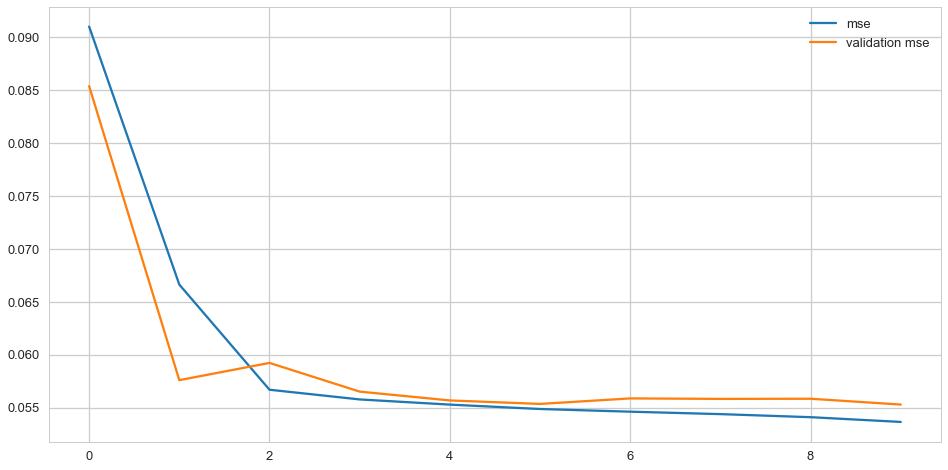

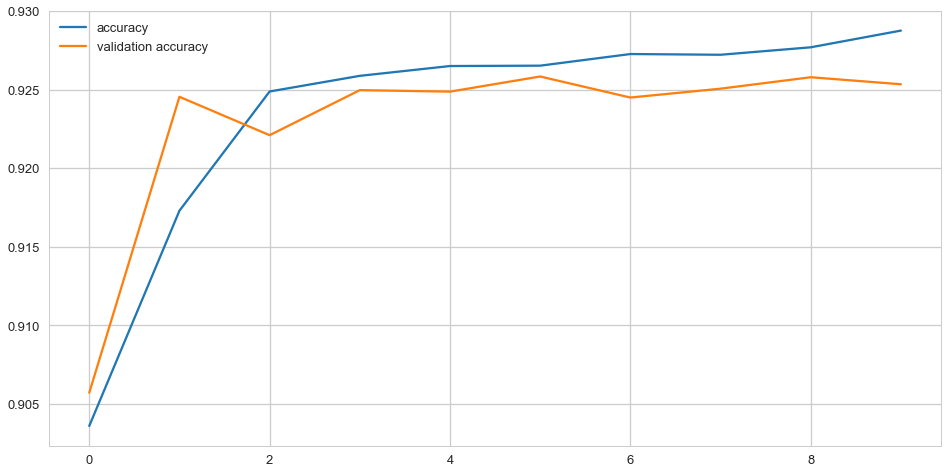

In [32]:
plt.plot(history.history["loss"], label="mse")
plt.plot(history.history["val_loss"], label="validation mse")
plt.legend()
plt.show()

plt.plot(history.history["acc"], label="accuracy")
plt.plot(history.history["val_acc"], label="validation accuracy")
plt.legend()
plt.show()

There is a bit of over-fitting but nothing alarming. The loss/acc doesn't seem to be evolving anymore so we might just be at maximum performance for this model. Let's see how it performs :

In [33]:
y_pred = (model.predict(X_test) > 0.5).reshape(-1) * 1

print("Neural Network :", '\n')
print(classification_report(y_test, y_pred))
print("Baseline accuracy = {:.2f}".format(1 - y_test.mean()))
print("Model accuracy = {:.2f}".format((y_pred == y_test).mean()))

Neural Network : 

             precision    recall  f1-score   support

          0       0.93      0.99      0.96     38578
          1       0.72      0.34      0.46      4016

avg / total       0.91      0.93      0.91     42594

Baseline accuracy = 0.91
Model accuracy = 0.93


Better Results. The Neural Network does a better job on all the metrics when compared to the Random Forest Classifier. In particular there is an improvement on the precision side of the minority class which means that when the model predicts "1" it is actually more often a "1" than before.

**!** : *Grid-Search and fine tuning is always a good idea once we start having a good model but it isn't relevent in this situation as we're not trying to have the best possible model. Also, these results were generated on a single split of the data, but I actually did some cross-validation and made sure everything was stable : these results should be reflected on the test dataset.*

## Testing
Now that we have a model that performs (reasonably) well on the training data, let's see how things go on the test samples.

We start by training a fresh Neural Network on the whole training set :

In [34]:
training_features = X.columns

input_layer = Input(shape=(X.shape[1],))
x = Dense(64, activation="sigmoid")(input_layer)
x = Dense(16, activation="sigmoid")(x)
x = Dense(4, activation="sigmoid")(x)
output = Dense(1, activation="sigmoid")(x)

model = Model(inputs=[input_layer], outputs=[output])
model.compile(loss="mse", optimizer="adam", metrics=["accuracy"])

model.summary()
model.fit(x=X.values, y=y, batch_size=32, epochs=10, verbose=0)
print("Training complete !")

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 405)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 64)                25984     
_________________________________________________________________
dense_6 (Dense)              (None, 16)                1040      
_________________________________________________________________
dense_7 (Dense)              (None, 4)                 68        
_________________________________________________________________
dense_8 (Dense)              (None, 1)                 5         
Total params: 27,097
Trainable params: 27,097
Non-trainable params: 0
_________________________________________________________________
Training complete !


Then we import the test data and apply all the necessary transformations so that it can be used by our trained model :

In [35]:
data, target = get_data(TEST_DATA_PATH, drop_duplicated=False)

data["had_capital_gains"] = (data["capital gains"] != 0).astype(int)
data["had_capital_losses"] = (data["capital losses"] != 0).astype(int)
data["had_dividends"] = (data["dividends from stocks"] != 0).astype(int)
data["age_interval"] = (data["age"] > 25)*1. + (data["age"] > 40)*1.

for c in ["capital gains","capital losses",
          "dividends from stocks",
          "NoName", "wage per hour", "age"]:
    data.drop(c, axis=1, inplace=True)

dummies = pd.get_dummies(data.select_dtypes("object"))

The dataset has 99762 lines and 42 columns.
The target has 2 distinct values : "- 50000." and "50000+."
The value "- 50000." is the most common with a frequency of 93.80%.
Replaced the target modalities with 0 and 1 for "- 50000." and "50000+." respectively.
Replaced NaN in "type of hispanic" feature with "Do not know".
Number of remaining NaN values in dataset : 0
Number of numerical features : 8
Number of categorical features : 33


In [36]:
X = dummies.join(data.select_dtypes(exclude="object"))
y = target.copy()

In [37]:
for c in X:
    if c not in training_features:
        X.drop(c, axis=1, inplace=True)

for c in training_features:
    if c not in X.columns:
        X[c] = np.zeros(X.shape[0])

#### Results :

Finally, we predict using the pretrained Neural Network :

In [38]:
y_pred = (model.predict(X.values) > 0.5).reshape(-1) * 1

print("Neural Network :", '\n')
print(classification_report(y, y_pred))
print("Baseline accuracy = {:.3f}".format(1 - y.mean()))
print("Model accuracy = {:.3f}".format((y_pred == y).mean()))

Neural Network : 

             precision    recall  f1-score   support

          0       0.96      0.99      0.97     93576
          1       0.71      0.38      0.49      6186

avg / total       0.94      0.95      0.94     99762

Baseline accuracy = 0.938
Model accuracy = 0.952


As we expected, the model did perform well. This means that our training/evaluation process was reliable. In more detail, we did better than the baseline : 95.2% against 93.8% in accuracy. Moreover, the majority class recall is almost at a 100% and the minority class' precision is at more than 70% which is the best precision for the minority class we had so far. We also have the best f1-scores we had so far which makes the results all in all reasonably good.

## Conclusion

As a conclusion we would say that there were many ideas we couldn't explore. In particular, we couldn't really apply the most interesting resampling methods to overcome the class balance problem. We also couldn't do a proper dimensionality reduction on the categorical features using MCA. This was because of a lack of processing power and we are sure that these ideas would have proved fruitful.

Another thing is that we probably should have done more feature engineering by grouping some categorical feature modalities and maybe creating some more informative features, but as the purpose isn't really to get the model with the absolutely best performance we chose to carry on with the analysis.